# Análise de Dados e Gráficos com *R*

O objetivo deste exercício é demonstrar algumas funcionalidades da linguagem *R* para análise estatística e geração de gráficos.

As dependências de software já estão instaladas na imagem *Docker* disponibilizada no repositório do minicurso, que também determina as versões dos pacotes que vamos usar. Rode a célula abaixo para carregar os pacotes que vamos usar, e listar o ambiente disponível.

Apesar de não garantir a reprodutibilidade, poder controlar as versões do sistema operacional, da linguagem *R*, e de cada pacote que usamos ajuda a compartilhar código, facilita o trabalho colaborativo, e ajuda a resolver problemas no futuro, quando as versões podem mudar.

In [53]:
# Pacotes usados
library(dplyr) # Manipulação de dados
library(tidyr) # Manipulação de dados
library(ggplot2) # Geração de gráficos
library(datasauRus) # Dados utilizados

sessionInfo() # Lista ambiente desta seção

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] datasauRus_0.1.4 ggplot2_3.3.3    tidyr_1.1.3      dplyr_1.0.6     

loaded via a namespace (and not attached):
 [1] pillar_1.6.0      compiler_4.0.3    base64enc_0.1-3   tools_4.0.3      
 [5] digest_0.6.27     uuid_0.1-4        lattice_0.20-44   nlme_3.1-152     
 [9] jsonlite_1.7.2    evaluate_0.14     lifecycle_1.0.0   

## O Quarteto de Anscombe e o Datasaurus

Agora já devemos estar com o conjunto de dados carregado. Esse conjunto de dados foi elaborado para demonstrar que sempre devemos desconfiar de sínteses feitas a partir de um conjunto de dados, mesmo quando os desvios padrão e intervalos de confiança são incluídos. O conjunto de dados que vamos usar é uma extensão dos conceitos discutidos no [Quarteto de Anscombe](https://pt.wikipedia.org/wiki/Quarteto_de_Anscombe), representados pela tabela retirada da Wikipédia e reproduzida abaixo:

![Anscombe](img/anscombe.png)

Veja que todas as tentativas de sintetizar as diferenças entre esse conjunto de dados falham em demonstrar a diferença que podemos observar com os gráficos.

Neste exercício, nós vamos fazer uma análise estatística "do avesso". Vamos começar com medidas de sumário e depois verificar o comportamento dos dados com gráficos. Isso é exatamente o inverso do que devemos fazer num cenário real.

### Conjuntos de dados no *R*

Antes de começar, vamos observar alguns conjuntos de dados bastante simples. As três funções abaixo geram dados *y* normalmente distribuídos, positivamente correlacionados, e negativamente correlacionados com um vetor de entrada *x*.

In [54]:
random_y <- function(x) {
    rnorm(length(x))
}

poscor_y <- function(x) {
    x + rnorm(length(x), mean = 0, sd = 0.05)
}

negcor_y <- function(x) {
    -x + rnorm(length(x), mean = 0, sd = 0.05)
}

samples = 30
xs = seq(0, 1, length.out = samples)

first_df = data.frame(x = rep(xs, 3)) %>%
    mutate(y = c(random_y(xs), poscor_y(xs), negcor_y(xs)),
           dataset = c(rep("A", samples),                                
                       rep("B", samples),
                        rep("C", samples)))

Fazendo gráficos de dispersão dos *x* e *y* gerados, vemos:

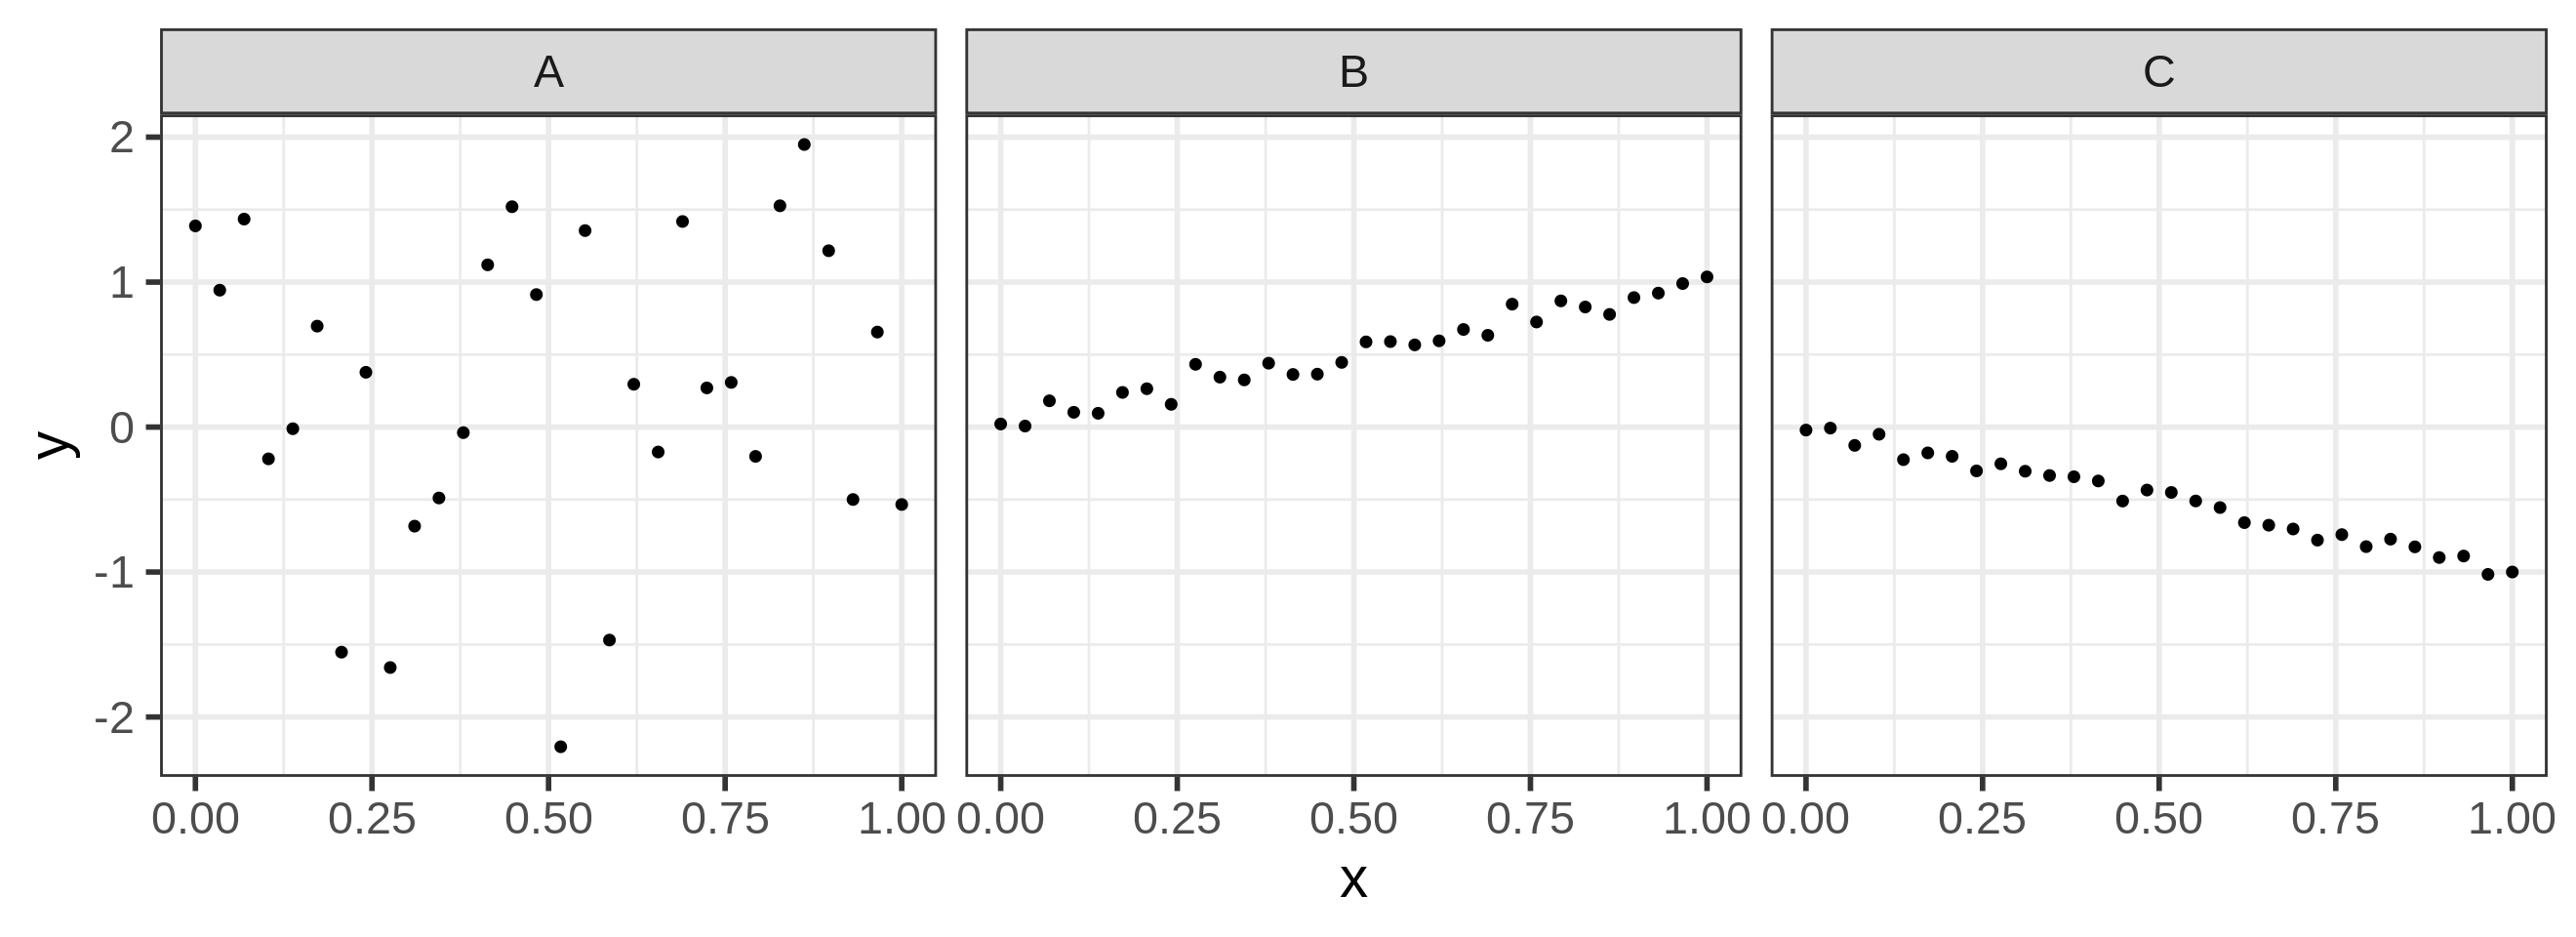

In [55]:
options(repr.plot.width = 22, repr.plot.height = 8)

ggplot() +
    geom_point(data = first_df,
              aes(x, y),
              size = 3) +
    facet_wrap(dataset ~ .) +
    theme_bw(base_size = 35)

Calculando algumas sínteses estatísticas comuns, temos a tabela:

In [56]:
summary_first_df = first_df %>%
    group_by(dataset) %>%
    summarize(mean_x = mean(x),
              mean_y = mean(y),
              ci_95_x = (1.96 * sd(x)) / sqrt(n()),
              ci_95_y = (1.96 * sd(y)) / sqrt(n()),
              cor_pearson = cor(x, y)) %>%
    ungroup()

summary_first_df

dataset,mean_x,mean_y,ci_95_x,ci_95_y,cor_pearson
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,0.5,0.2550271,0.1086296,0.3853900,0.06694347
B,0.5,0.5106364,0.1086296,0.1085511,0.97932393
C,0.5,-0.4990220,0.1086296,0.1081581,-0.99046235


### O Datasaurus

Agora, podemos começar a análise "do avesso", usando o Datasaurus. Primeiro, vamos usar a função `str` para começar a entender o conjunto de dados que temos à mão:

In [57]:
str(data.frame(datasaurus_dozen))

'data.frame':	1846 obs. of  3 variables:
 $ dataset: chr  "dino" "dino" "dino" "dino" ...
 $ x      : num  55.4 51.5 46.2 42.8 40.8 ...
 $ y      : num  97.2 96 94.5 91.4 88.3 ...


Para facilitar a leitura da saída, transformamos a variável `datasaurus_dozen`, definida pelo pacote `datasauRus`, num `data.frame`. Experimente a saída sem usar o DataFrame. Qual o tipo dos dados? De qual pacote esse tipo vem?

Vemos que temos 1846 observações, correspondentes a cada linha, e três variáveis, correspondentes às colunas. Um DataFrame é basicamente uma tabela, e é padrão colocar as observações, ou experimentos, nas linhas, e as variáveis nas colunas.

Se quisermos saber quais são os valores da coluna `dataset`, podemos fazer:

In [58]:
unique(datasaurus_dozen$dataset)

[1] "dino"       "away"       "h_lines"    "v_lines"    "x_shape"   
 [6] "star"       "high_lines" "dots"       "circle"     "bullseye"  
[11] "slant_up"   "slant_down" "wide_lines"

Podemos também observar as primeiras linhas desse DataFrame com a função `head`:

In [59]:
datasaurus_dozen %>% head(n = 10)

dataset,x,y
<chr>,<dbl>,<dbl>
dino,55.3846,97.1795
dino,51.5385,96.0256
dino,46.1538,94.4872
dino,42.8205,91.4103
dino,40.7692,88.3333
dino,38.7179,84.8718
dino,35.6410,79.8718
dino,33.0769,77.5641
dino,28.9744,74.4872


Note que estamos usando o operador `%>%`, ou *pipe*, para passar a variável `datasaurus_dozen` como primeiro argumento da função `head`. Podemos fazer o mesmo com a função `sample_n`, para observar uma amostra aleatória do DataFrame:

In [60]:
datasaurus_dozen %>% sample_n(size = 10)

dataset,x,y
<chr>,<dbl>,<dbl>
circle,84.62672,39.487078
wide_lines,66.31381,98.931027
h_lines,59.75150,89.731933
wide_lines,35.83829,53.351488
x_shape,42.36782,73.638272
v_lines,69.55109,58.401098
slant_down,45.42038,5.372409
dino,70.76920,91.025600
high_lines,65.59236,20.694173


Agora, vamos criar um novo DataFrame chamado `df`, contento as médias das colunas `x` e `y`, e outras sínteses:

In [69]:
df = datasaurus_dozen %>%
    group_by(dataset) %>%
    summarize(mean_x = mean(x),
              mean_y = mean(y),
              ci_95_x = (1.96 * sd(x)) / sqrt(n()),
              ci_95_y = (1.96 * sd(y)) / sqrt(n()),
              median_x = median(x),
              median_y = median(y),
              cor_pearson = cor(x, y)) %>%
    ungroup()

df

dataset,mean_x,mean_y,ci_95_x,ci_95_y,median_x,median_y,cor_pearson
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
away,54.26610,47.83472,2.758293,4.431037,53.34030,47.53527,-0.06412835
bullseye,54.26873,47.83082,2.758197,4.430376,53.84209,47.38294,-0.06858639
circle,54.26732,47.83772,2.756679,4.429440,54.02321,51.02502,-0.06834336
dino,54.26327,47.83225,2.757523,4.430323,53.33330,46.02560,-0.06447185
dots,54.26030,47.83983,2.757950,4.429466,50.97677,51.29929,-0.06034144
h_lines,54.26144,47.83025,2.757647,4.431059,53.06968,50.47353,-0.06171484
high_lines,54.26881,47.83545,2.757780,4.431079,54.16869,32.49920,-0.06850422
slant_down,54.26785,47.83590,2.757789,4.430438,53.13516,46.40131,-0.06897974
slant_up,54.26588,47.83150,2.758133,4.430850,54.26135,45.29224,-0.06860921


Estamos usando a função `group_by`, do pacote `dplyr`, para agrupar as linhas do DataFrame e calcular as estatísticas separadamente. O que é o intevalo de confiança a 95%? E o índice de correlação de Pearson?

Relembrando, podemos estimar o índice de correlação de Pearson, escrito

$$
\rho = \dfrac{\text{cov}(X,Y)}{\sigma_x \sigma_y}\text{,}
$$

usando a fórmula

$$
r = \dfrac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2(y_i - \overline{y})^2}}\text{,}
$$

e podemos estimar o desvio padrão fazendo

$$
\sigma = \sqrt{\dfrac{1}{N} \sum_{i=1}^N (x_i - \mu)^2}\text{.}
$$

### Questão

Qual é a sua interpretação da tabela com sínteses estatísticas? Baseando-se nela, você diria que há diferenças entre os `datasets`? Quais?
Nesse ponto da análise, o que você faria para explorar melhor os dados?

### Quais gráficos podem ajudar?

Vamos colocar os dados em gráficos. Quais gráficos devemos fazer? Se apenas representarmos os mesmos dados da tabela, não vamos aprender nada novo. Os dois gráficos abaixo apenas reforçam a impressão de que os conjuntos de dados são idênticos.

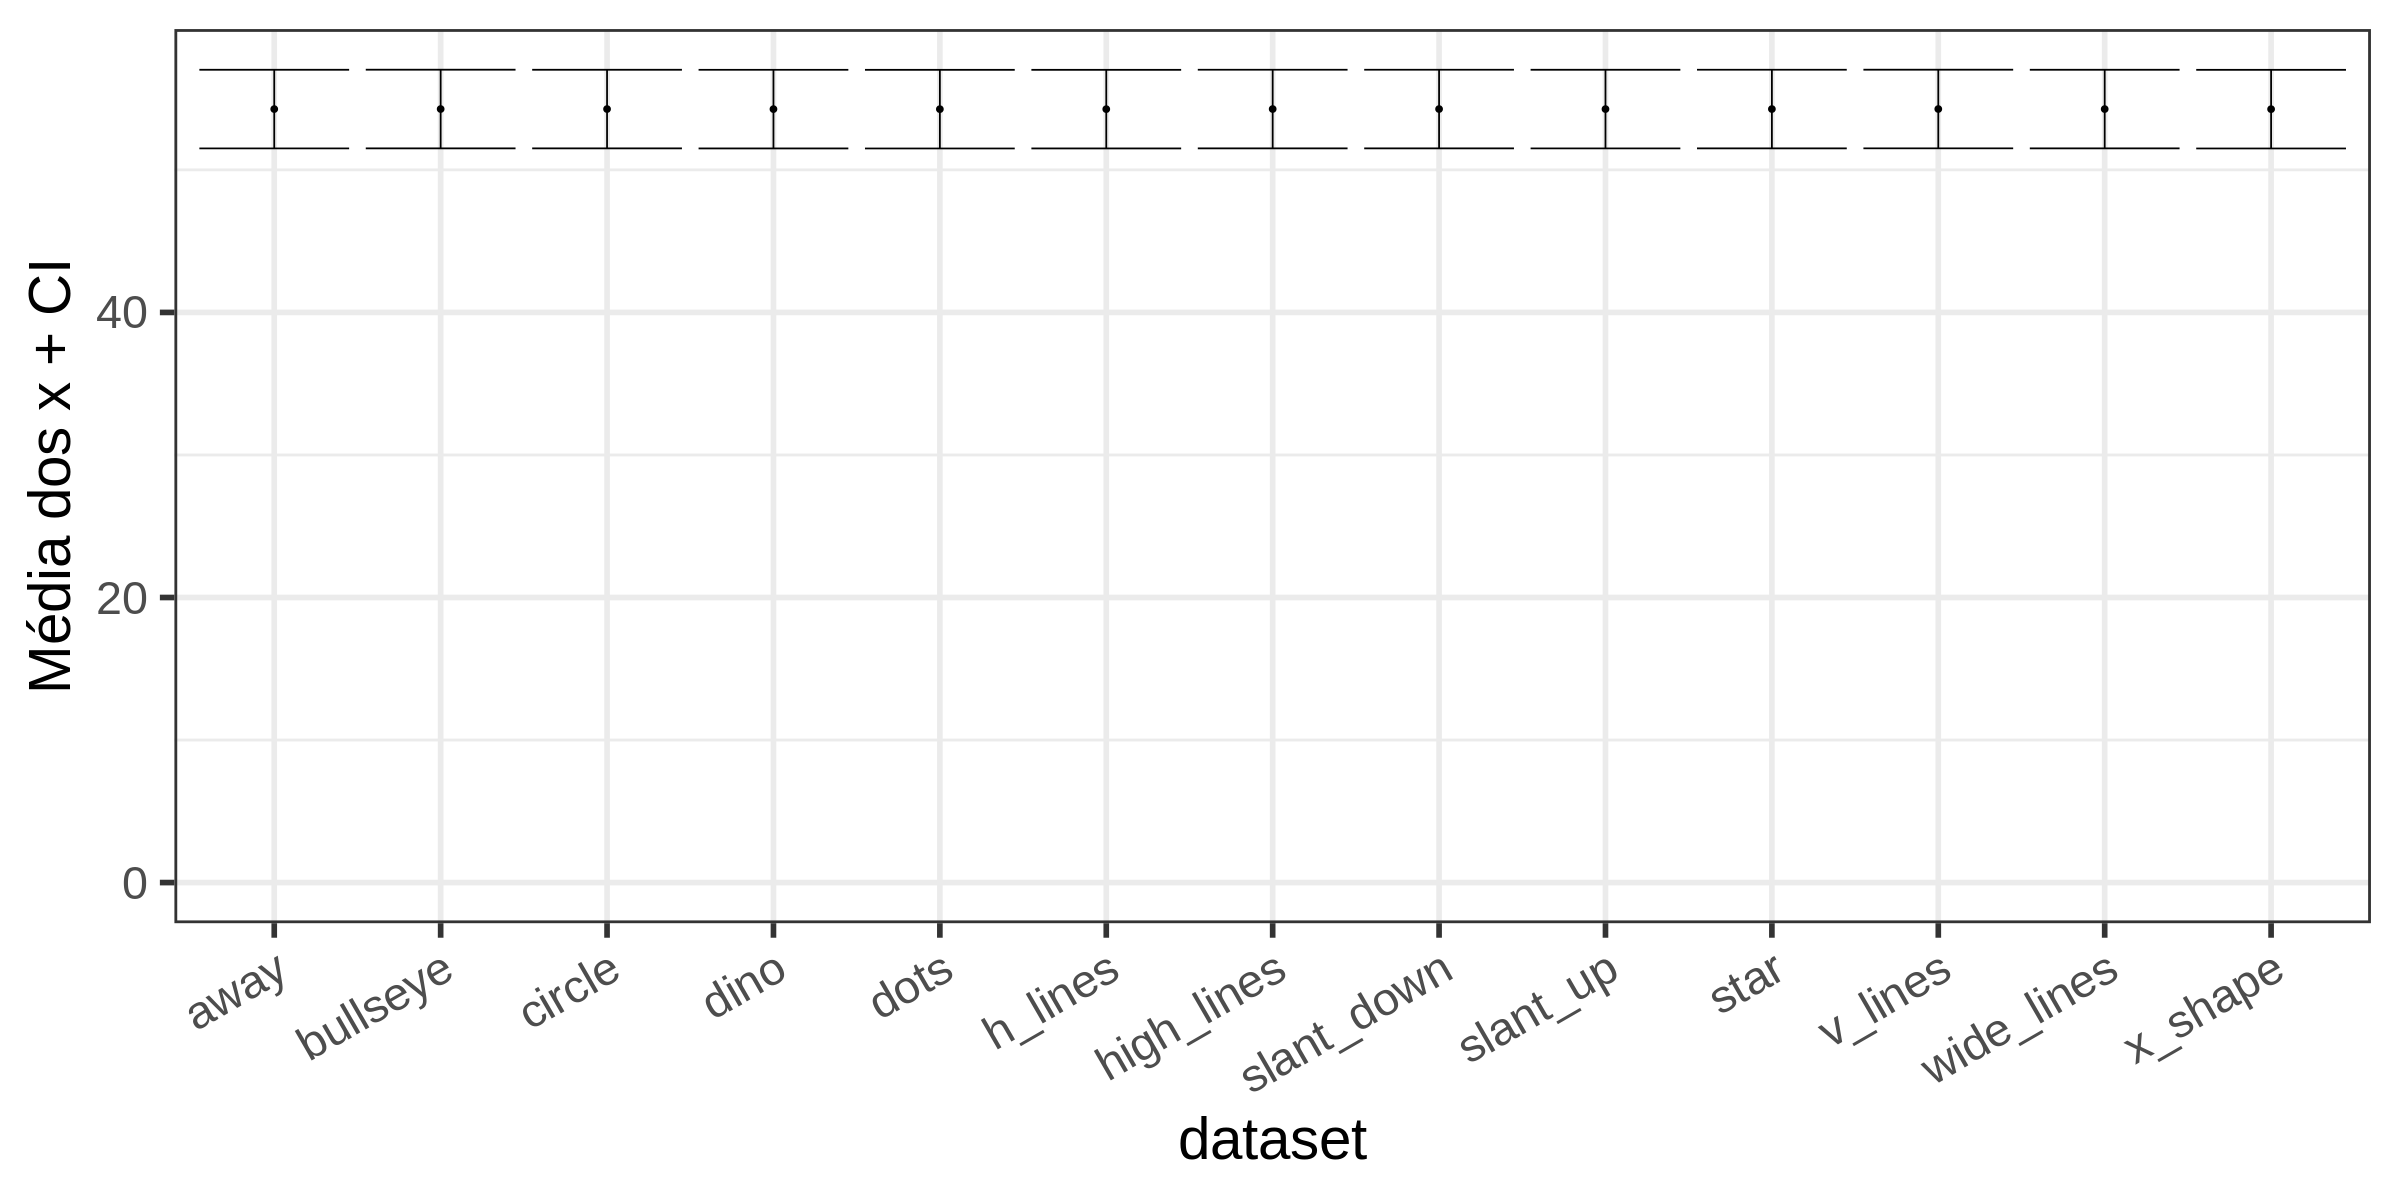

In [62]:
options(repr.plot.width = 20, repr.plot.height = 10)

ggplot(df) +
    geom_point(aes(x = dataset, y = mean_x)) +
    geom_errorbar(aes(ymin = mean_x - ci_95_x,
                     ymax = mean_x + ci_95_x,
                     x = dataset)) +
    ylim(0, NA) +
    ylab("Média dos x + CI") +
    theme_bw(base_size = 35) +
    theme(legend.position = "none",
        axis.text.x = element_text(angle = 30, hjust = 1))

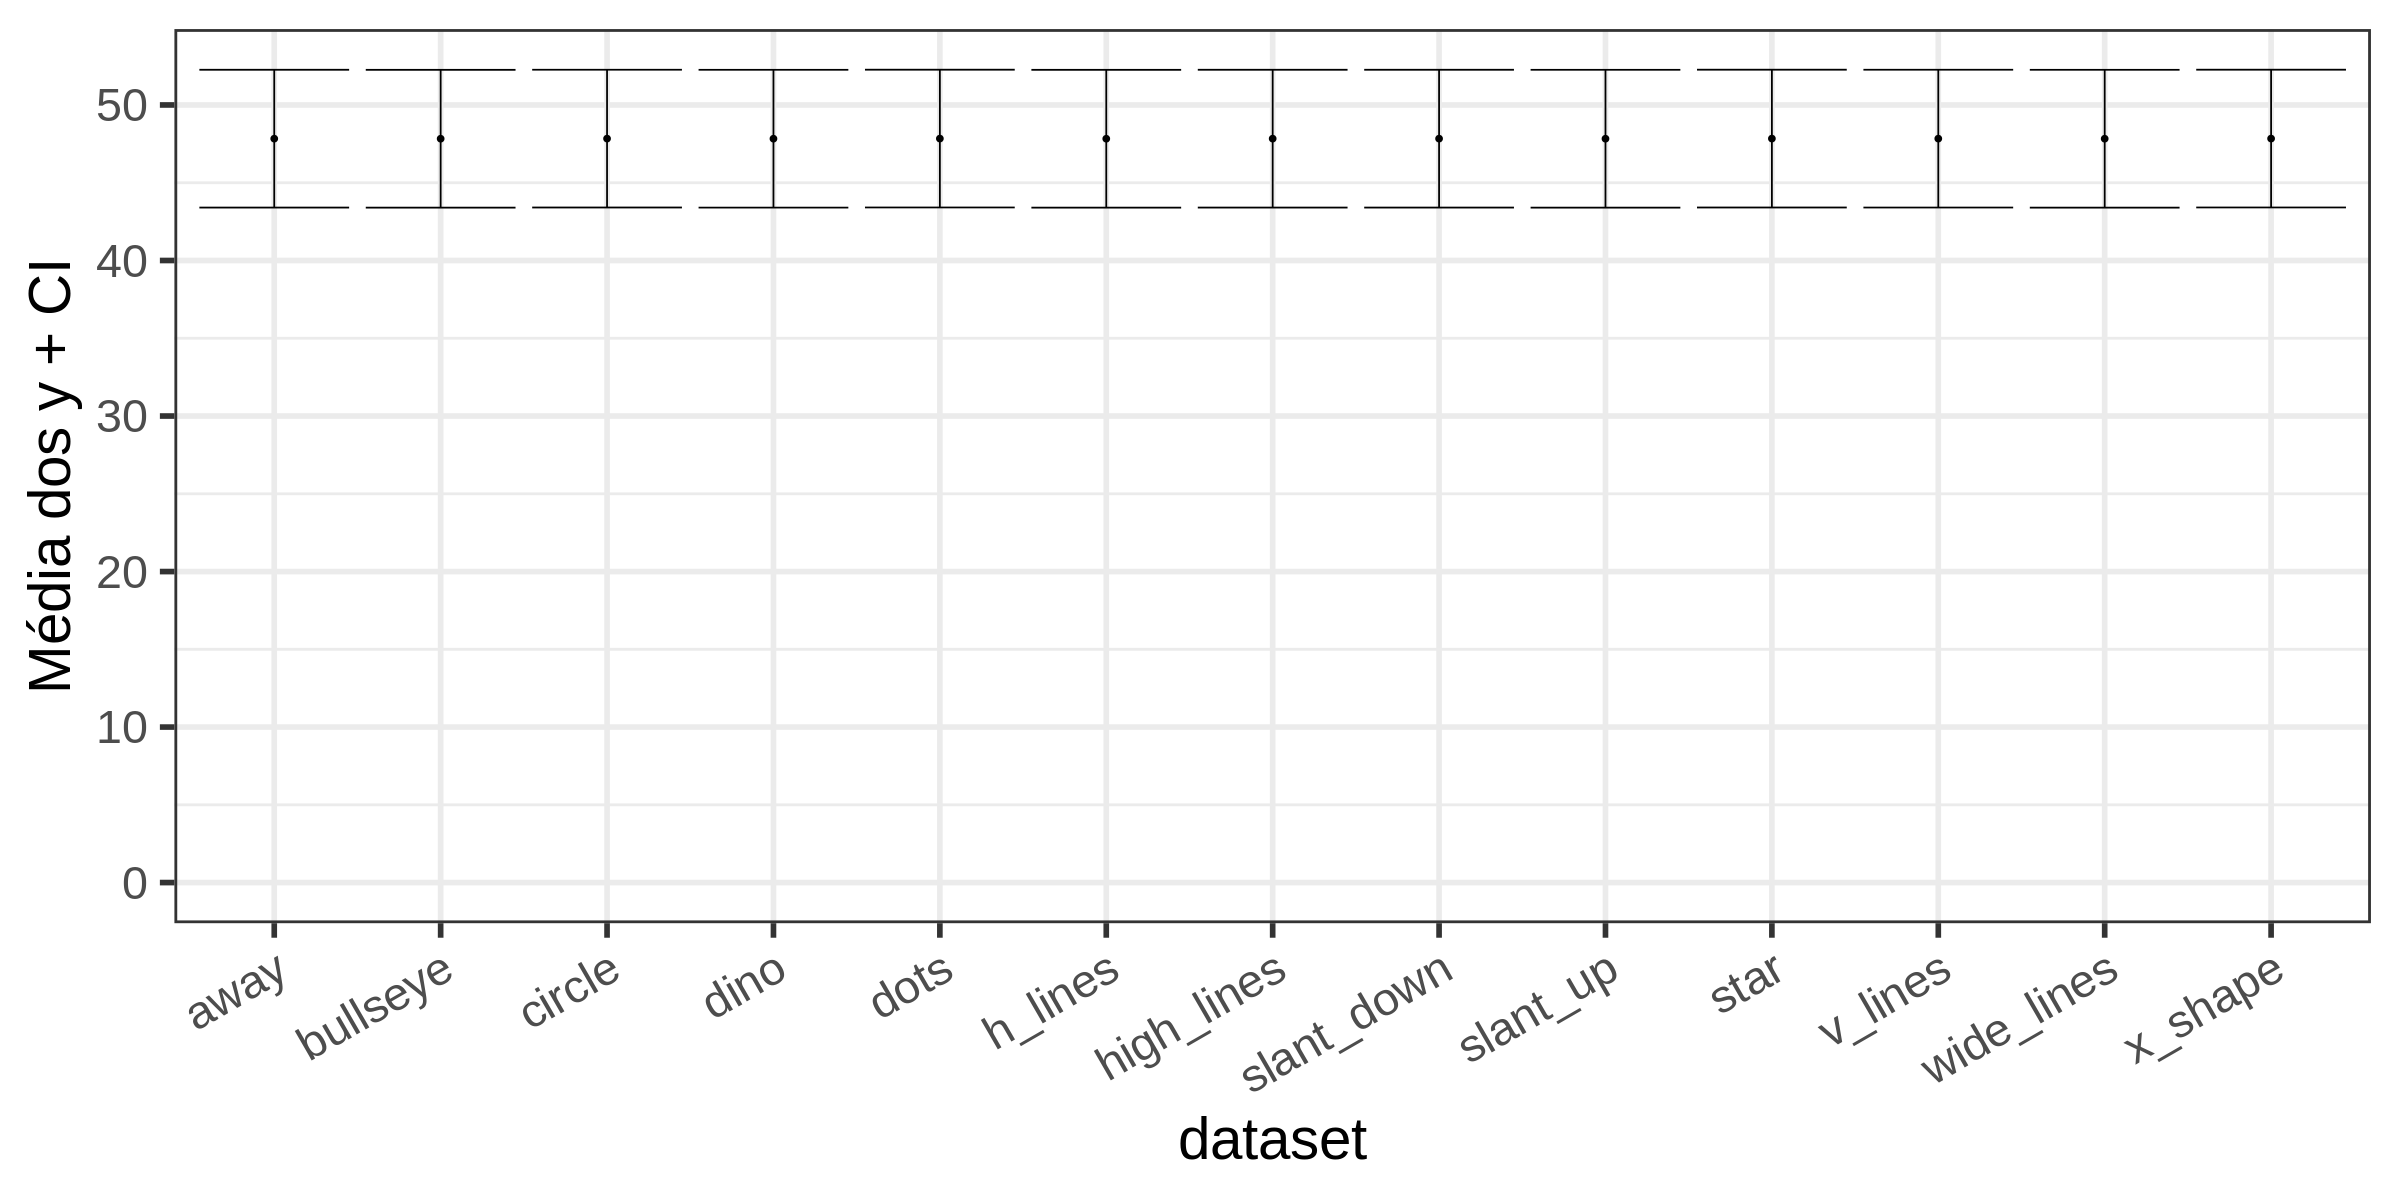

In [63]:
options(repr.plot.width = 20, repr.plot.height = 10)

ggplot(df) +
    geom_point(aes(x = dataset, y = mean_y)) +
    geom_errorbar(aes(ymin = mean_y - ci_95_y,
                     ymax = mean_y + ci_95_y,
                     x = dataset)) +
    ylim(0, NA) +
    ylab("Média dos y + CI") +
    theme_bw(base_size = 35) +
    theme(legend.position = "none",
        axis.text.x = element_text(angle = 30, hjust = 1))

## Desvendando o Datasaurus

O [Datasaurus Dozen](http://www.thefunctionalart.com/2016/08/download-datasaurus-never-trust-summary.html) é uma extensão do conceito apresentado no [Quarteto de Anscombe](https://pt.wikipedia.org/wiki/Quarteto_de_Anscombe). Se fizermos um gráfico de dispersão com as variáveis $x$ e $y$, veremos que cada um dos 13 conjuntos de dados (12 + o Datasaurus) é completamente diferente!

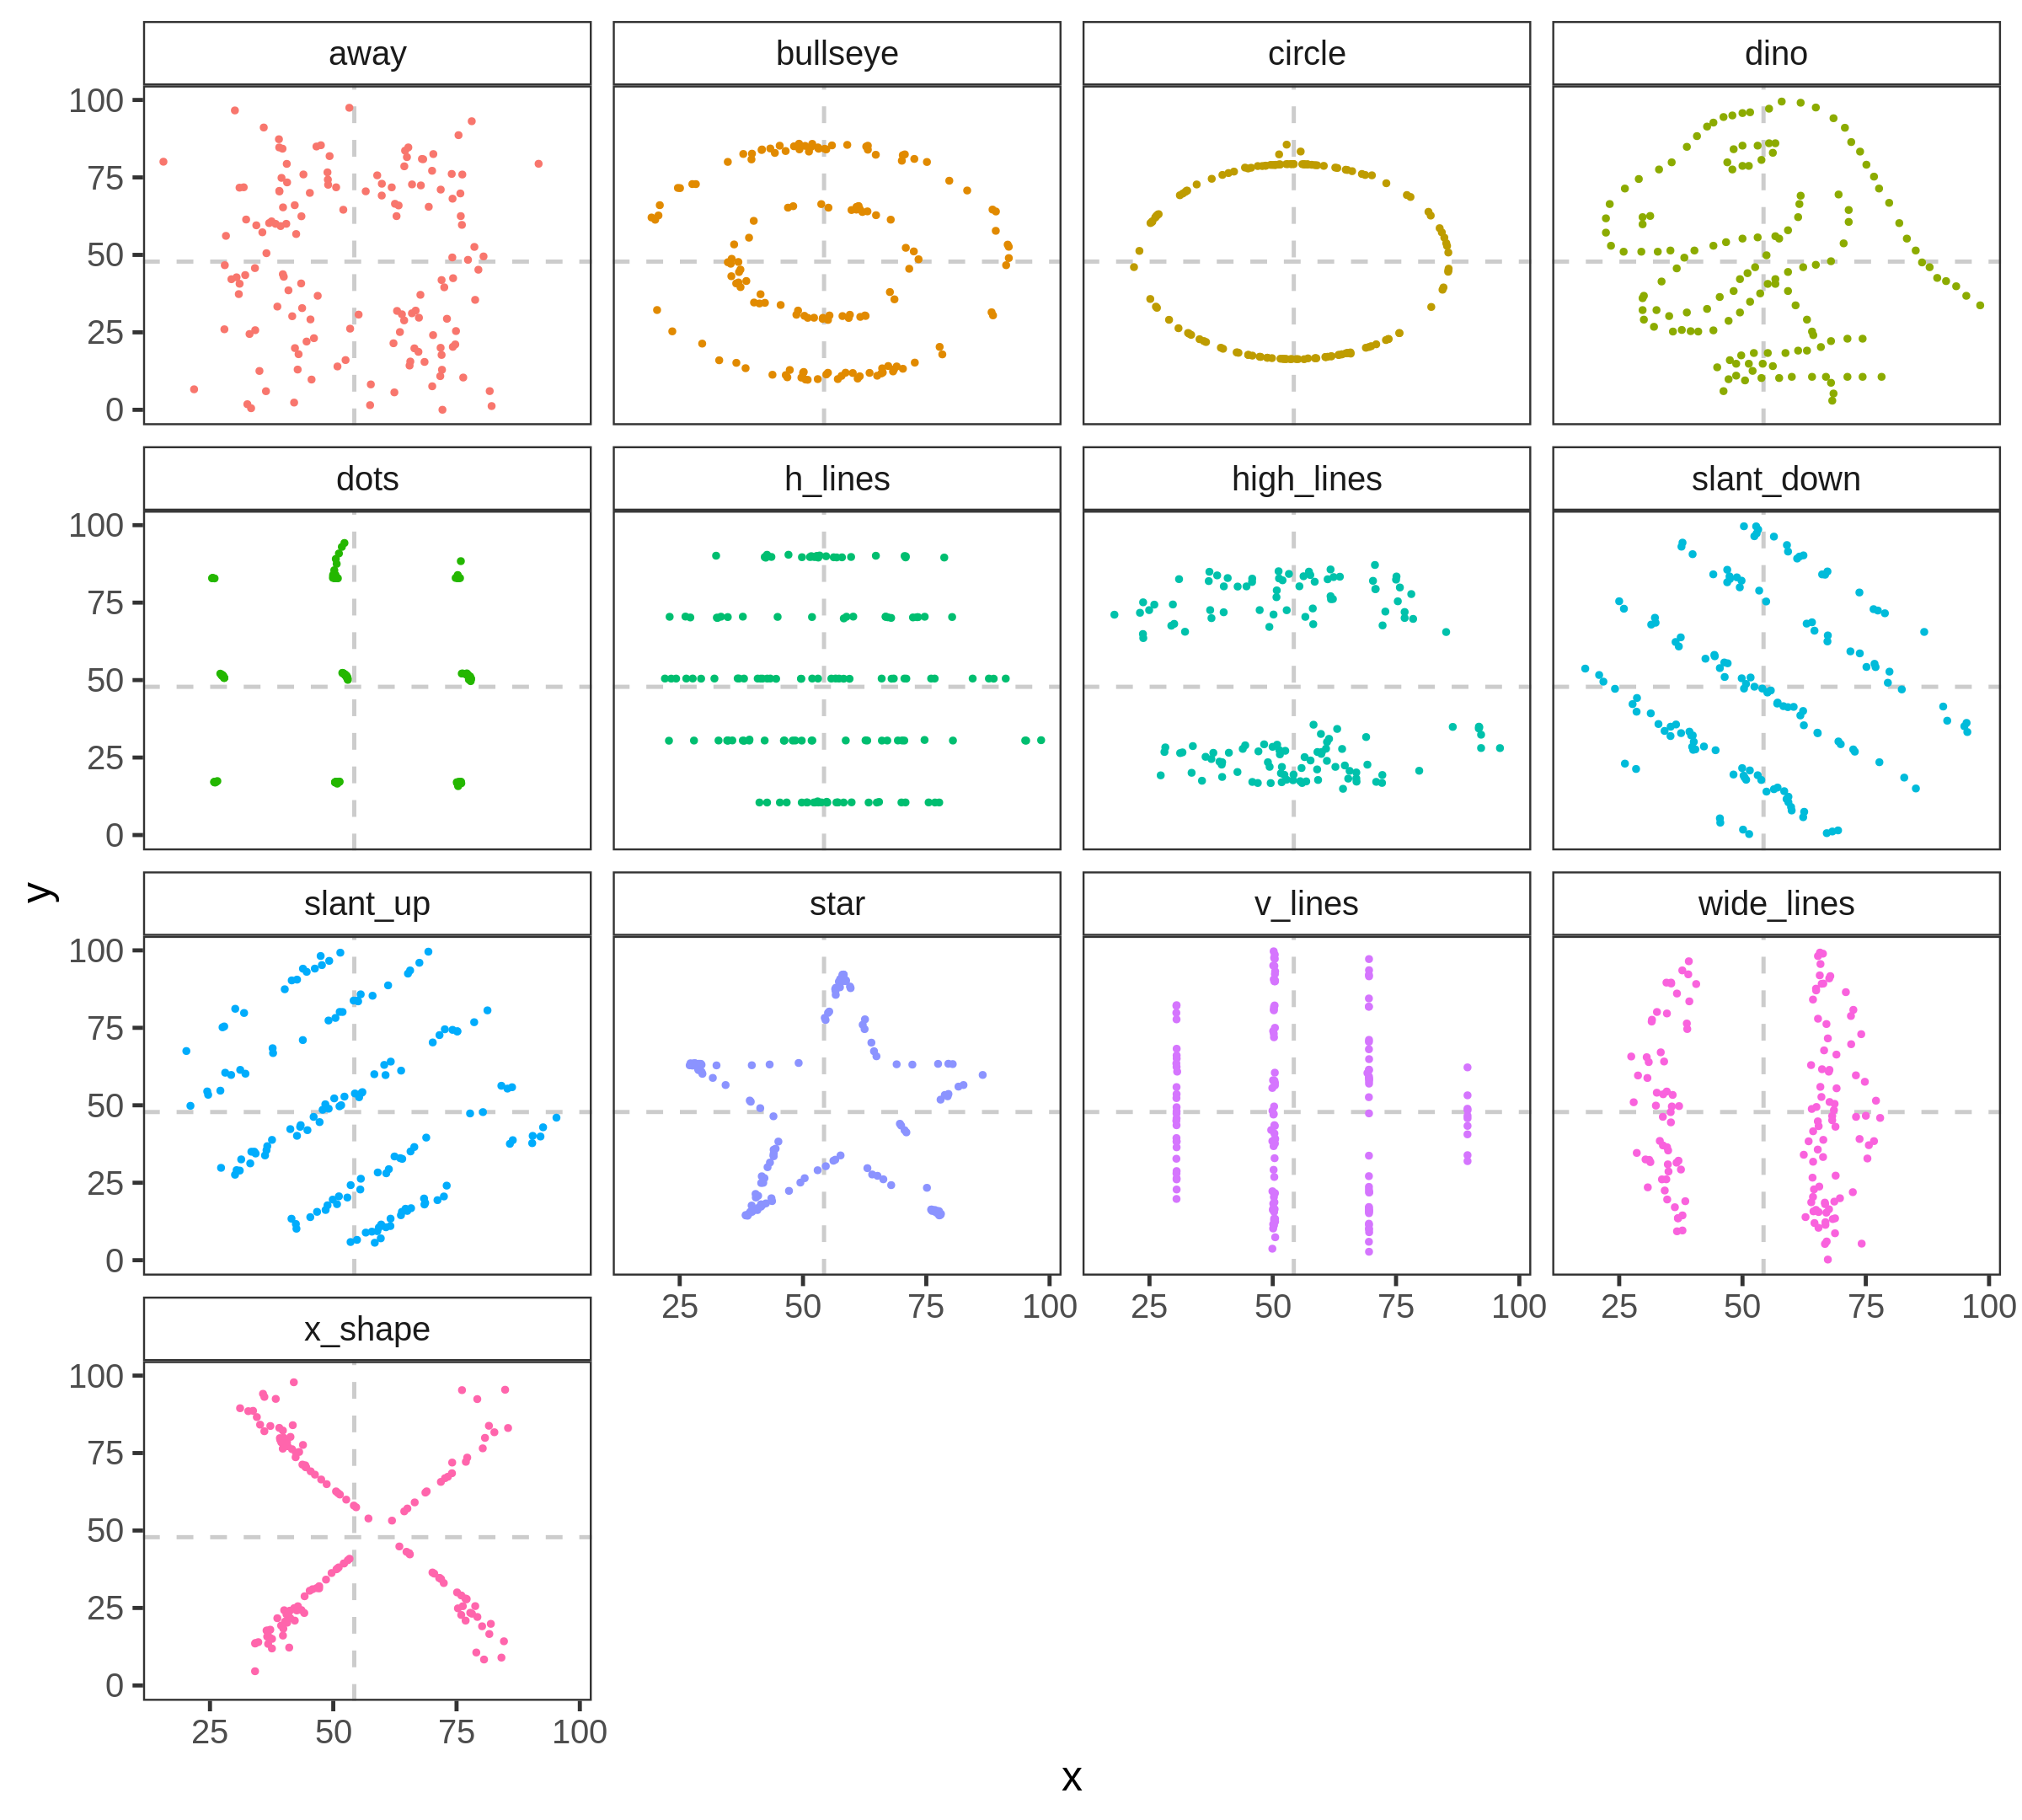

In [64]:
options(repr.plot.width = 20, repr.plot.height = 18)

ggplot() +
    geom_hline(data = df,
               size = 1.4,
               linetype = 2,
               alpha = 1,
               color = "gray80",
               aes(yintercept = mean_y)) +
    geom_vline(data = df,
               size = 1.4,
               linetype = 2,
               alpha = 1,
               color = "gray80",
               aes(xintercept = mean_x)) +
    geom_point(data = datasaurus_dozen,
               size = 2,
               aes(x = x, y = y, color = dataset)) +
    theme_bw(base_size = 30) +
    theme(legend.position = "none",
         panel.grid = element_blank(),
         strip.background = element_rect(fill = "transparent")) +
    facet_wrap(~ dataset, ncol = 4)

Os painéis da figura acima mostram cada um dos conjuntos de dados, com linhas tracejadas marcando as médias dos dados em cada eixo.

Esses conjuntos foram criados a partir do Datasaurus (o conjunto "Dino"), através da perturbação progressiva dos pontos, mas mantendo um conjunto de métricas estatísticas constante. O processo é descrito em mais detalhes [neste post](https://www.autodesk.com/research/publications/same-stats-different-graphs), e o objetivo é mostrar que toda análise estatística deve começar por gráficos bem escolhidos.

## Exercício: Análise Estatística

Agora que já compreendemos que existem diferenças, procure encontrar uma ou mais formas de distinguir os conjuntos de dados no Datasaurus Dozen usando análises estatísticas.

Você pode copiar e modificar os trechos de código acima, pode procurar na documentação dos pacotes /R/ que usamos (ou outros), e também pode conversar com outros participantes e com o instrutor do curso.

Veja também as duas sugestões abaixo.

### Modelos Lineares

Aqui, estamos usando o `geom_smooth` da bilioteca `ggplot2`. No entanto, parece que todas as regressões são iguais! Como prosseguir?

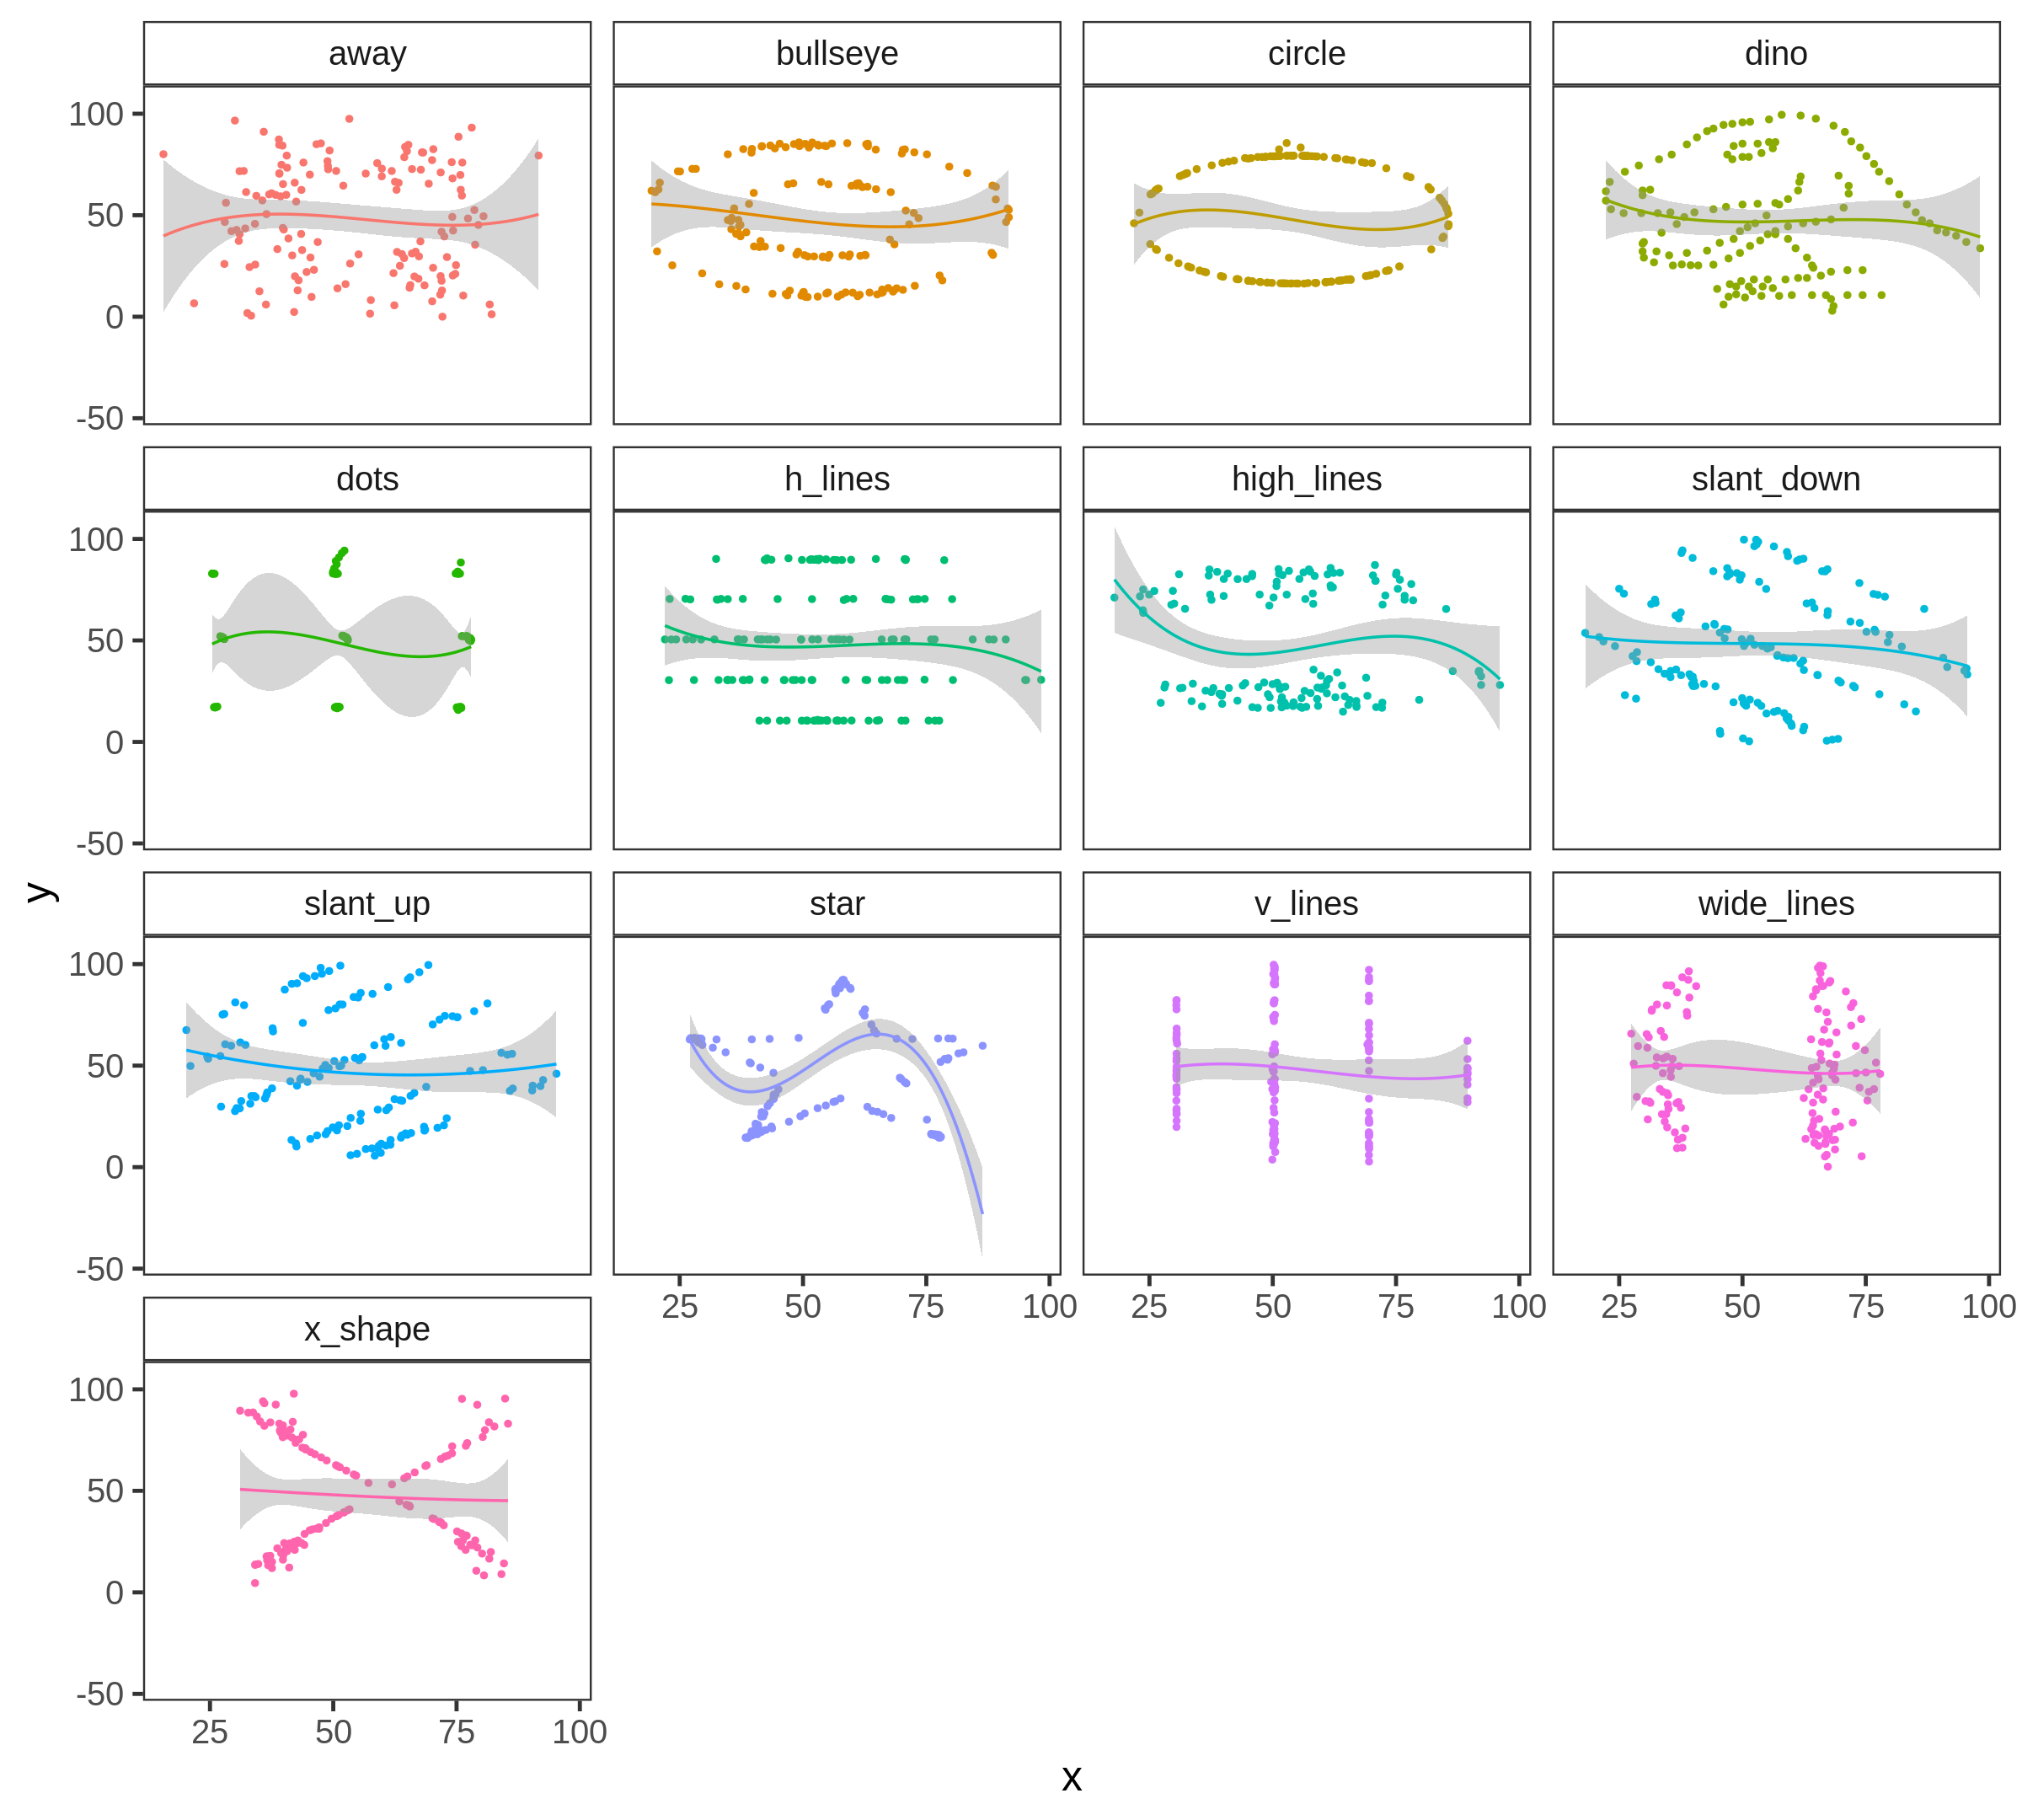

In [67]:
options(repr.plot.width = 20, repr.plot.height = 18)

ggplot() +
    geom_point(data = datasaurus_dozen,
               size = 2,
               aes(x = x, y = y, color = dataset)) +
    geom_smooth(data = datasaurus_dozen,
                method = "lm",
                formula = y ~ x + I(x ^ 2) + I(x ^ 3),
                aes(x = x, y = y, color = dataset)) +
    theme_bw(base_size = 30) +
    theme(legend.position = "none",
         panel.grid = element_blank(),
         strip.background = element_rect(fill = "transparent")) +
    facet_wrap(~ dataset, ncol = 4)

### Histogramas

Modifique os exemplos anteriores e use o `geom_histogram` do pacote `ggplot2`. Elabore um argumento sobre o que você interpreta a partir das distribuições produzidas para cada conjunto de dados.

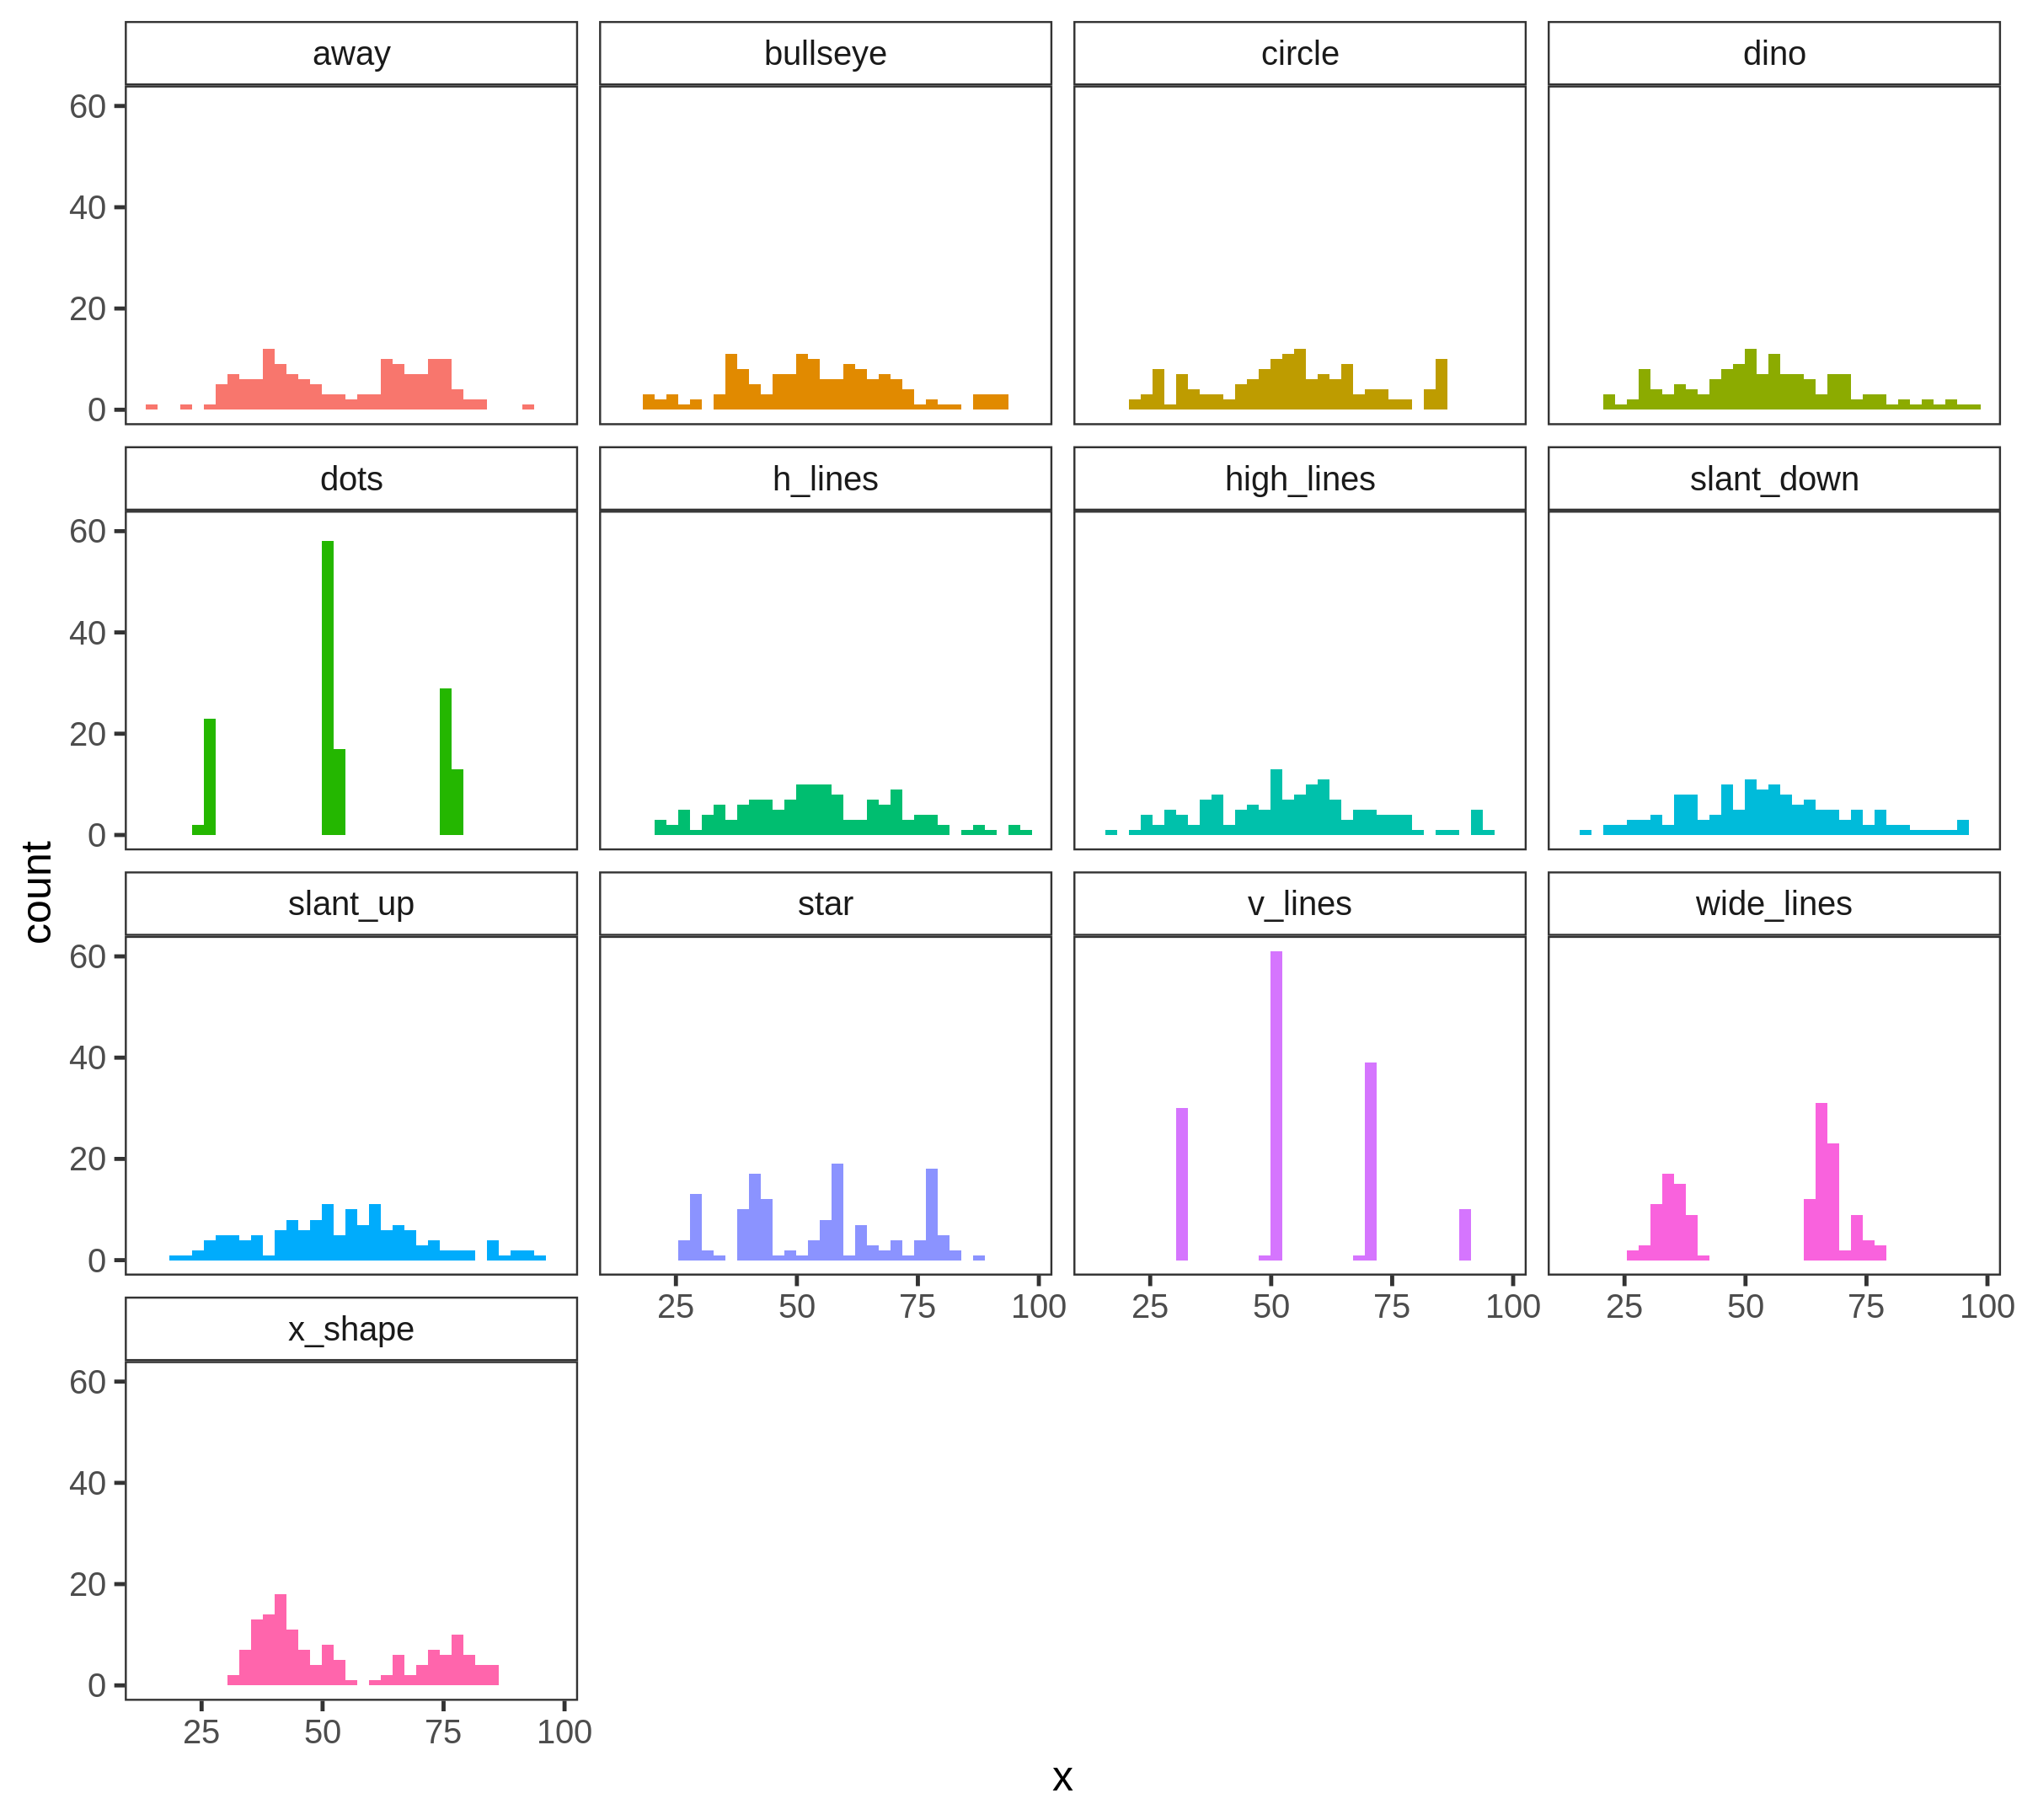

In [68]:
options(repr.plot.width = 20, repr.plot.height = 18)

ggplot() +
    geom_histogram(data = datasaurus_dozen,               
                   aes(x = x, fill = dataset),                              
                   bins = 35) +
    theme_bw(base_size = 30) +
    theme(legend.position = "none",
         panel.grid = element_blank(),
         strip.background = element_rect(fill = "transparent")) +
    facet_wrap(~ dataset, ncol = 4)